In [1]:
%matplotlib inline
import numpy as np


In [2]:
import numpy as np

def metropolis(e1, e2, t):
    """
    Evaluate metropolis condition with:
    
      e1 :  Energy function for current state
      e2 :  Energy function for proposed state
      t  :  temperature
      
    Always swap if new state is better.  Take disadvantageous swap with probability
    p = exp(-(e2-e1)/t).  For simulated annealing, t gets smaller with higher iterations.
    """
    if e2 < e1:
        return True
    
    x = (e2-e1)/t
    
    if np.random.rand() < np.exp(-x):
        return True
    return False


def simulated_annealing(x0, energy_fun, perm_fun, 
                        update_fun=None,
                        steps=10000, t0=1.0, tau=100,
                        report_steps=100,
                        report=False):
    x = x0.copy()
    e = np.zeros(shape=(steps,))
    swaps = list()
    for t in np.arange(0, steps):
        x_cand = x.copy()
        perm_fun(x_cand)
        e1 = energy_fun(x)
        e2 = energy_fun(x_cand)
        temp = np.exp(-t/tau)
        accept = metropolis(e1, e2, temp)
        if accept:
            x = x_cand
            e[t] = e2
        else:
            e[t] = e1
        swaps.append(accept)
        if update_fun is not None:
            update_fun(accept)
            
        if report and t % report_steps == 0:
            print('[{0}] Energy = {1}, T={2}'.format(t, e[t], temp))
        
    return x, e, swaps


def permute_two(mat, i1, i2):
    """
    Re-order matrix by swapping two rows / columns
    """
    if i1 == i2:
        return
    
    # Row exchange
    row1 = np.array(mat[i1, :])
    row2 = np.array(mat[i2, :])
    mat[i1, :] = row2
    mat[i2, :] = row1
    
    # Column exchange
    col1 = np.array(mat[:, i1])
    col2 = np.array(mat[:, i2])
    mat[:, i1] = col2
    mat[:, i2] = col1
    

def random_permute_two(mat):
    i1 = np.random.randint(0, mat.shape[0])
    i2 = np.random.randint(0, mat.shape[0])
    permute_two(mat, i1, i2)
    return i1, i2
 
    
def random_permutation_matrix(n):
    indices = np.arange(0,n)
    shuffled = np.random.permutation(indices)
    
    mat = np.zeros(shape=(n,n))
    
    for i in indices:
        j = shuffled[i]
        mat[i,j] = 1
    
    return shuffled, mat


class ReorderPermuter:
    """
    This is just a wrapper class for the random row/column swap function that does additional 
    book-keeping on the index array.  After the algorithm is complete, the index array will have been
    re-ordered to provide lookup of labels associated with the matrix or to generate the permutation
    matrix solved for by simulated annealing.
    """
    
    def __init__(self, original_mat, indices=None, n=None):
        if indices is None:
            if n is None:
                raise Exception('Must supply either array of indices or value of n (matrix dimension)')
            indices = np.arange(0, n)
            n = indices.shape[0]
        self.n = n
        self.indices = indices
        self.original_mat = original_mat.copy()
        
    def random_row_column_reorder(self, mat):
        i1, i2 = random_permute_two(mat)
        # swap indices
        self._candidate_indices = (i1, i2)
        
    def row_column_reorder(self, mat, i1, i2):
        permute_two(mat, i1, i2)
        self._candidate_indices = (i1, i2)
        
    def update_indices(self, accept):
        r = (0,0)
        if accept:
            i1 = self._candidate_indices[0]
            i2 = self._candidate_indices[1]
            tmp = self.indices[i2]
            self.indices[i2] = self.indices[i1]
            self.indices[i1] = tmp
            r = (i1,i2)
        return r
        
    def get_permutation_matrix(self):
        
        permutation_mat = np.zeros(shape=(self.n, self.n))
        for i in np.arange(0, self.n):
            permutation_mat[i, self.indices[i]] = 1.0
        return permutation_mat
            
    def reorder_with_permutation(self, mat=None):
        
        if mat is None:
            mat = self.original_mat
        
        pmat = self.get_permutation_matrix()
        # Row / column reorder with permutation matrix
        return np.matmul(pmat.transpose(), np.matmul(mat, pmat))
    
    def reorder_permutation_inverse(self, mat=None):
        
        if mat is None:
            mat = self.original_mat
            
        pmat = self.get_permutation_matrix()
        return np.matmul(pmat, np.matmul(mat, pmat.transpose()))


def rbf_cov(n, length_scale=None):
    """
    Simple rbf kernel covariance with "distance" uniformly tied to
    index in the matrix (creates band-diagonal matrix for testing)
    """
    if length_scale is None:
        length_scale = n/4
    scale = np.power(length_scale, 2)
    cov = np.zeros(shape=(n, n))
    for i in np.arange(0, n):
        for j in np.arange(0, n):
            d = np.power(i-j, 2) / scale
            cov[i,j] = np.exp(-d)
    return cov


def penalty_weighting_matrix(n):
    
    mat = np.zeros(shape=(n,n))
    
    for i in np.arange(0,n):
        for j in np.arange(0,n):
            mat[i,j] = (i-j)*(i-j)
            
    return mat

            
def get_scoring_function(n):
    
    penalty_mat = penalty_weighting_matrix(n)
    norm = np.power(n, 4) / 2
    
    # Pre-calculating penalty weights and multiplying thusly is
    # like 50x faster than loop calculation below.  "If you're
    # looping over elements of a matrix, you're doing it wrong."
    return lambda mat: np.sum(np.abs(mat)*penalty_mat) / norm


def matrix_score(m):
    """
    Objective function to penalize off-diagonal matrix mass.  Yields 
    zero for a diagonal matrix.  Minimization of this function over 
    row/column ordering minimizes matrix bandwidth (akin to banded 
    """
    score = 0
    m_abs = np.abs(m)
    norm = np.power(m.shape[0], 4) / 2
    for i in np.arange(0, m.shape[0]):
        for j in np.arange(0, m.shape[1]):
            score += m_abs[i,j]*(i-j)*(i-j)
            
    return score / norm


def cleanup(x0, perm_fun=permute_two, energy_fun=None, update_fun=None):
    """
    A one-pass exhaustive pair-wise greedy swap can be more effective at finalizing the
    matrix reorder than waiting many iterations for random swaps to find.
    """
    if energy_fun is None:
        energy_fun = get_scoring_function(x0.shape[0])
    x = x0.copy()
    current_score = energy_fun(x)
    e = list()
    print('E={0}'.format(current_score))
    for i in np.arange(1, x0.shape[0]):
        for j in np.arange(i, x0.shape[0]):
            candidate = x.copy()
            perm_fun(candidate, i, j)
            score = energy_fun(candidate)
            swap = False
            if score < current_score:
                current_score = score
                e.append(current_score)
                x = candidate
                swap = True
                print('E={0}, swapped {1} and {2}'.format(current_score, i, j))
                
            if update_fun is not None:
                r = update_fun(swap)

    return x, e
            

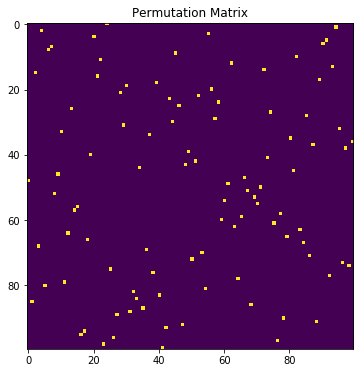

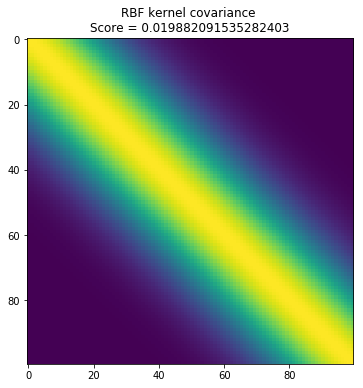

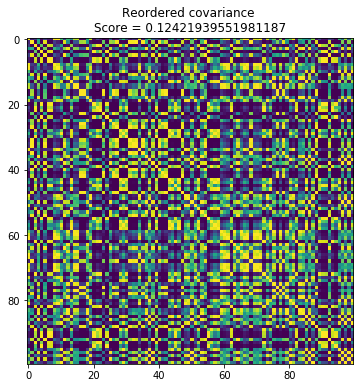

In [3]:
n = 100
figsize=(6,6)

# initial covariance
cov = rbf_cov(n)
indices, perm = random_permutation_matrix(n)
cov_reorder = np.matmul(np.transpose(perm), np.matmul(cov, perm))

plt.figure(figsize=figsize)
plt.imshow(perm)
plt.title('Permutation Matrix')
plt.show()

plt.figure(figsize=figsize)
plt.title('RBF kernel covariance \nScore = {0}'.format(matrix_score(cov)))
plt.imshow(cov)
plt.show()

plt.figure(figsize=figsize)
plt.title('Reordered covariance \nScore = {0}'.format(matrix_score(cov_reorder)))
plt.imshow(cov_reorder)
plt.show()



In [4]:
scoring_fun = get_scoring_function(cov_reorder.shape[0])

permuter = ReorderPermuter(n=n, original_mat=cov_reorder)

print(scoring_fun(cov_reorder))

mat, e, swap = simulated_annealing(x0=cov_reorder, 
                                   energy_fun=scoring_fun, 
                                   perm_fun=permuter.random_row_column_reorder,
                                   update_fun=permuter.update_indices,
                                   steps=15000, report=True)

print('Done')

0.12421939551981216
[0] Energy = 0.1241004852183855, T=1.0
[100] Energy = 0.12733733379582493, T=0.36787944117144233
[200] Energy = 0.12368087361119456, T=0.1353352832366127
[300] Energy = 0.12445183926478084, T=0.049787068367863944
[400] Energy = 0.12490596648434249, T=0.01831563888873418
[500] Energy = 0.12481473164829425, T=0.006737946999085467
[600] Energy = 0.12427844113698333, T=0.0024787521766663585
[700] Energy = 0.11966807832264573, T=0.0009118819655545162
[800] Energy = 0.10740284695302997, T=0.00033546262790251185
[900] Energy = 0.08221825814017407, T=0.00012340980408667956
[1000] Energy = 0.0658752429433117, T=4.5399929762484854e-05
[1100] Energy = 0.05393871560468073, T=1.670170079024566e-05
[1200] Energy = 0.04879219562487384, T=6.14421235332821e-06
[1300] Energy = 0.04289352223201092, T=2.2603294069810542e-06
[1400] Energy = 0.03981221386773906, T=8.315287191035679e-07
[1500] Energy = 0.03722088078662132, T=3.059023205018258e-07
[1600] Energy = 0.03262685669971358, T=1.1

Done


In [5]:
print(permuter.indices)

mat, e_cleanup = cleanup(x0=mat,
                         energy_fun=scoring_fun,
                         perm_fun=permuter.row_column_reorder,
                         update_fun=permuter.update_indices)

#e = np.concatenate((e, e_cleanup))
print(permuter.indices)

print('Done')

[24 94  4 55 20 91 90  6 45  7 82 22 62 93 72 21  2 89 39 30 56 28 52 43
 46 58 13 85 74 57 44 29 95 10 37 80 99 87 97 19 49 73 51 48 34 81  9 66
  0 61 71 67  8 69 60 70 15 77 65 14 59 75 63 83 12 79 18  3 84 36 53 86
 50 96 98 25 38 92 64 11  5 54 32 40 33  1 68 35 31 27 78 88 47 42 17 16
 26 76 23 41]
E=0.01991076447534526
E=0.019907210809197953, swapped 7 and 9
E=0.019905381055676005, swapped 8 and 9
E=0.019903334039735515, swapped 15 and 16
E=0.019900804698753036, swapped 24 and 25
E=0.01989810091404105, swapped 27 and 28
E=0.01989486170318081, swapped 39 and 40
E=0.019888276912127887, swapped 57 and 59
E=0.019885010711808083, swapped 58 and 59
E=0.01988209153528259, swapped 67 and 68
[24 94  4 55 20 91 90  7  6 45 82 22 62 93 72  2 21 89 39 30 56 28 52 43
 58 46 13 74 85 57 44 29 95 10 37 80 99 87 97 49 19 73 51 48 34 81  9 66
  0 61 71 67  8 69 60 70 15 14 77 65 59 75 63 83 12 79 18 84  3 36 53 86
 50 96 98 25 38 92 64 11  5 54 32 40 33  1 68 35 31 27 78 88 47 42 17 16
 26 76 23

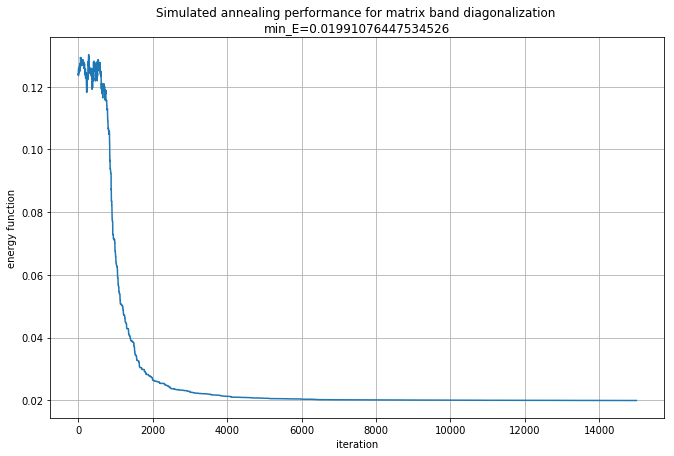

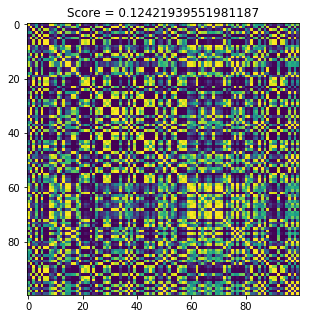

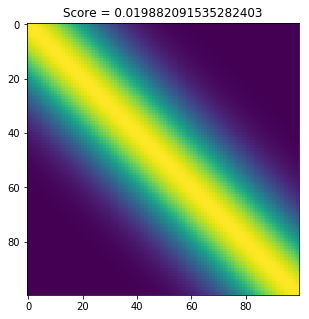

In [6]:
plt.figure(figsize=(11,7))
plt.plot(e)
plt.xlabel('iteration')
plt.ylabel('energy function')
plt.title('Simulated annealing performance for matrix band diagonalization \n'
          + 'min_E={0}'.format(np.min(e)))

plt.grid(True)
plt.show()

plt.figure(figsize=(5,5))
plt.title('Score = {0}'.format(matrix_score(cov_reorder)))
plt.imshow(cov_reorder)
plt.show()

plt.figure(figsize=(5,5))
plt.title('Score = {0}'.format(matrix_score(mat)))
plt.imshow(mat)
plt.show()

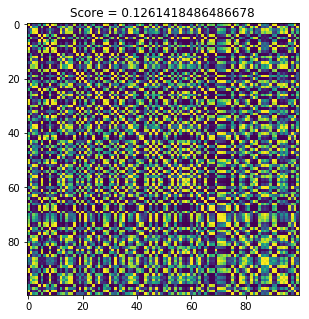

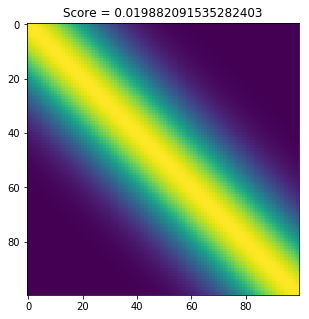

In [8]:
# Test effective permutation inverse
transform_mat = permuter.reorder_permutation_inverse()

plt.figure(figsize=(5,5))
plt.title('Score = {0}'.format(matrix_score(permuter.original_mat)))
plt.imshow(permuter.original_mat)
plt.show()

plt.figure(figsize=(5,5))
plt.title('Score = {0}'.format(matrix_score(transform_mat)))
plt.imshow(transform_mat)
plt.show()

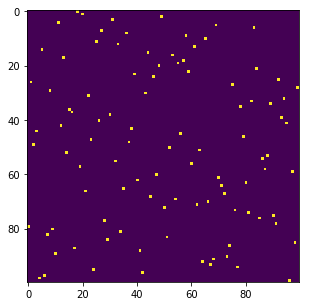

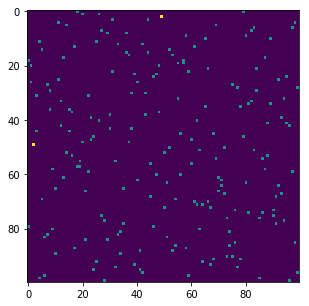

[18 20 49 31 11 69 83 27 36 58 65 25 33 61  5 44 53 13 57 55 48 84 59 39
 46 92  1 75 99  8 43 22 94 82 89 78 15 16 30 93 26 95 12 38  3 56 79 23
 37  2 52 63 14 88 86 32 60 19 87 97 47 70 40 80 71 35 21 72 45 54 66 62
 50 76 81 90 85 28 91  0  9 34  7 51 29 98 74 17 41 10 73 68 64 67 77 24
 42  6  4 96]
[18 20 49 31 11 69 83 27 36 58 65 25 33 61  5 44 53 13 57 55 48 84 59 39
 46 92  1 75 99  8 43 22 94 82 89 78 15 16 30 93 26 95 12 38  3 56 79 23
 37  2 52 63 14 88 86 32 60 19 87 97 47 70 40 80 71 35 21 72 45 54 66 62
 50 76 81 90 85 28 91  0  9 34  7 51 29 98 74 17 41 10 73 68 64 67 77 24
 42  6  4 96]


In [9]:
plt.figure(figsize=(5,5))
plt.imshow(perm)
plt.show()

solved_perm_mat = permuter.get_permutation_matrix()

plt.figure(figsize=(5,5))
plt.imshow(solved_perm_mat.transpose()+perm)
plt.show()

print(indices)
print(permuter.indices)

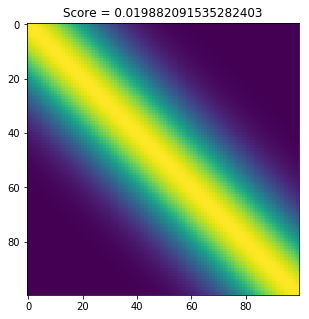

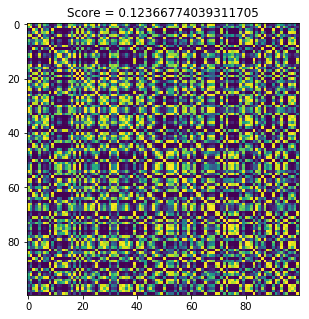

In [29]:
#permutation by random swaps

cov_copy = cov.copy()

for i in np.arange(0,n*10):
    i1 = np.random.randint(0,n)
    i2 = np.random.randint(0,n)
    permute_two(cov_copy, i1, i2)
    
plt.figure(figsize=(5,5))
plt.title('Score = {0}'.format(matrix_score(cov)))
plt.imshow(cov)
plt.show()

plt.figure(figsize=(5,5))
plt.title('Score = {0}'.format(matrix_score(cov_copy)))
plt.imshow(cov_copy)
plt.show()
